## Import libraries

In [35]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


# Load dataset

In [36]:
df = pd.read_csv("gtsrb_dataset.csv")

### relevant classes

In [37]:
speed_classes = [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12]

### change label

In [38]:
new_labels = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
    7: 5,
    8: 7,
    9: 8,
    10: 9,
    11: 10,
    12: 11
}

df_speed = pd.DataFrame(columns=df.columns)

for index, row in df.iterrows():
    original_label = row["label"]
    if original_label in speed_classes:
        
        
        new_row = row.copy()

        new_label = new_labels[original_label]
        new_row["label"] = new_label

        df_speed = pd.concat([df_speed, pd.DataFrame([new_row])], ignore_index=True)
print(df_speed)

      label                            path
0         0  ./GTSRB_png/01/train_00150.png
1         0  ./GTSRB_png/01/train_00151.png
2         0  ./GTSRB_png/01/train_00152.png
3         0  ./GTSRB_png/01/train_00153.png
4         0  ./GTSRB_png/01/train_00154.png
...     ...                             ...
19465     4   ./GTSRB_png/05/test_12621.png
19466    11   ./GTSRB_png/12/test_12622.png
19467    11   ./GTSRB_png/12/test_12625.png
19468     5   ./GTSRB_png/07/test_12628.png
19469     9   ./GTSRB_png/10/test_12629.png

[19470 rows x 2 columns]


### see the distribution of the dataset

Distribuția etichetelor:
Etichetă 0: 2220 exemple
Etichetă 1: 2250 exemple
Etichetă 2: 1410 exemple
Etichetă 3: 1980 exemple
Etichetă 4: 1890 exemple
Etichetă 5: 1410 exemple
Etichetă 7: 1410 exemple
Etichetă 8: 1470 exemple
Etichetă 9: 2010 exemple
Etichetă 10: 1320 exemple
Etichetă 11: 2100 exemple


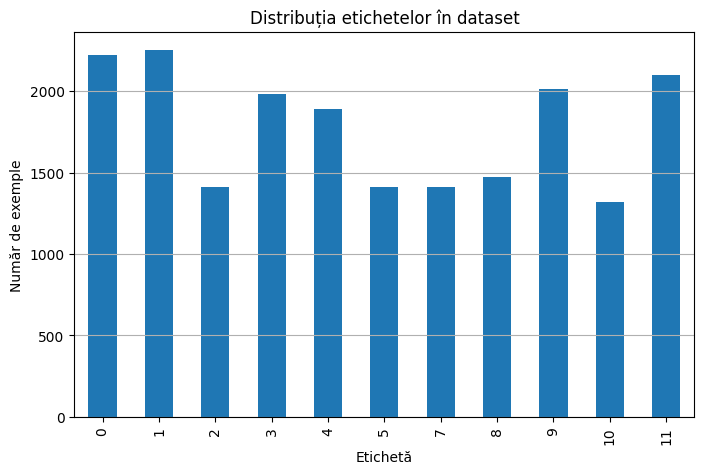

In [39]:
counts = df_speed["label"].value_counts().sort_index()

# Afișăm valorile în consolă
print("Distribuția etichetelor:")
for label, count in counts.items():
    print(f"Etichetă {label}: {count} exemple")

# Afișăm graficul
plt.figure(figsize=(8, 5))
counts.plot(kind="bar")
plt.title("Distribuția etichetelor în dataset")
plt.xlabel("Etichetă")
plt.ylabel("Număr de exemple")
plt.grid(axis='y')
plt.show()

### Balance the dataframe

In [40]:

balanced_df = []
max_per_class = 1000
for label,count in counts.items():
    df_label = df_speed[df_speed['label'] == label]
    if len(df_label) > max_per_class:
        df_sample = df_label.sample(n=max_per_class, random_state=10)
        balanced_df.append(df_sample)
    else:
        balanced_df.append(df_label)

df_speed = pd.concat(balanced_df).reset_index(drop=True)

### see the new distribution

Distribuția etichetelor:
Etichetă 0: 1000 exemple
Etichetă 1: 1000 exemple
Etichetă 2: 1000 exemple
Etichetă 3: 1000 exemple
Etichetă 4: 1000 exemple
Etichetă 5: 1000 exemple
Etichetă 7: 1000 exemple
Etichetă 8: 1000 exemple
Etichetă 9: 1000 exemple
Etichetă 10: 1000 exemple
Etichetă 11: 1000 exemple


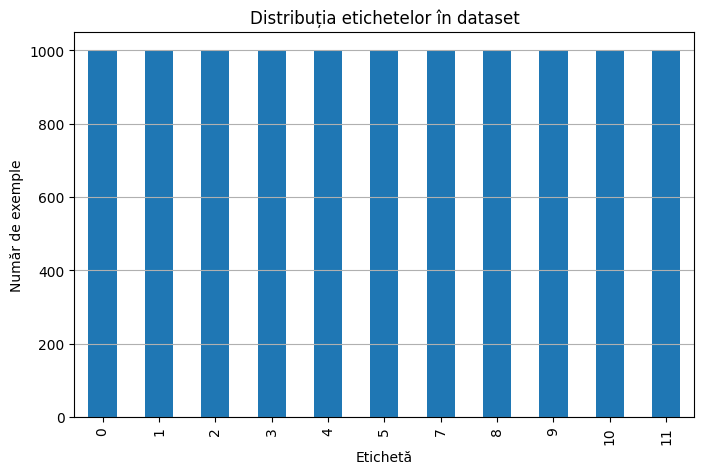

In [41]:
counts = df_speed["label"].value_counts().sort_index()

# Afișăm valorile în consolă
print("Distribuția etichetelor:")
for label, count in counts.items():
    print(f"Etichetă {label}: {count} exemple")

# Afișăm graficul
plt.figure(figsize=(8, 5))
counts.plot(kind="bar")
plt.title("Distribuția etichetelor în dataset")
plt.xlabel("Etichetă")
plt.ylabel("Număr de exemple")
plt.grid(axis='y')
plt.show()

## Prepare test train datasets

### shuffle the dataset

In [42]:
df_shuffled = df_speed.sample(frac=1, random_state=42).reset_index(drop=True)

### split the dataset

In [43]:
train_test_ratio = 0.8
train_size = (int)(len(df_shuffled) *0.8)
test_size = len(df_shuffled) - train_size
df_train    = df_shuffled.iloc[:train_size].reset_index(drop=True)
df_test     = df_shuffled.iloc[train_size:].reset_index(drop=True)

print("Train:", len(df_train), "– Test:", len(df_test))

Train: 8800 – Test: 2200


### Preprocess images

### image size

In [44]:
image_size = (50,50)

In [45]:

def preprocess_image(img, size=image_size):
    img = img.resize(size)
    img = img.convert("L")
    arr = np.array(img, dtype=np.float32)   
    arr = arr.flatten()
    arr /= 255
    return arr

### one hot encoding function

In [46]:
  
def one_hot(Y, num_classes):
    Y = Y.astype(int)
    m = Y.shape[0]
    Y_oh = np.zeros((num_classes, m), dtype=np.int32)
    Y_oh[Y, np.arange(m)] = 1
    return Y_oh

### change dataset format

### Prepare train df

In [47]:
total_pixels = image_size[0]*image_size[1]
num_classes = 12
number_images = len(df_train)

X_train = np.zeros((number_images, total_pixels), dtype=np.float32)
for i, path in enumerate(df_train["path"]):
    X_train[i,:] = preprocess_image(Image.open(path))
print(X_train.shape)
X_train = X_train.T
print(X_train.shape)
Y_train = one_hot(np.array(df_train["label"].values.astype("float32")), num_classes)



(8800, 2500)
(2500, 8800)


### Prepare test df

In [48]:
number_images = len(df_test)
m_test = len(df_test)
X_test = np.zeros((total_pixels, number_images), dtype=np.float32)
for i, path in enumerate(df_test["path"]):
    X_test[:, i] = preprocess_image(Image.open(path))
Y_test = one_hot(np.array(df_test["label"].values.astype("float32")), num_classes)
print(X_test.shape)

(2500, 2200)


## Homework 2: Use tensorflow to create and train the neural network 

#### Do not change the code from above

In [ ]:
import tensorflow